In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import sys
from rasterio.plot import show


In [2]:
# Step 1: Load Time Series Data
time_series_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\time_series"

# Get the list of all TIFF files in the directory sorted by date
tif_files = sorted([f for f in os.listdir(time_series_dir) if f.endswith('.tif')])

# Load a sample TIFF file to extract coordinate bounds
sample_tif_path = os.path.join(time_series_dir, tif_files[0])

In [3]:
# Step 2: Determine the Coordinate Range
with rasterio.open(sample_tif_path) as src:
    bounds = src.bounds
    crs = src.crs

# Print the coordinate range
print(f"Coordinate Reference System (CRS): {crs}")
print(f"Coordinate Range (Bounding Box):")
print(f"  Min Longitude (West): {bounds.left}")
print(f"  Max Longitude (East): {bounds.right}")
print(f"  Min Latitude (South): {bounds.bottom}")
print(f"  Max Latitude (North): {bounds.top}")

Coordinate Reference System (CRS): EPSG:32720
Coordinate Range (Bounding Box):
  Min Longitude (West): 845580.0
  Max Longitude (East): 847160.0
  Min Latitude (South): 9329240.0
  Max Latitude (North): 9331190.0


In [4]:
# Step 3: Define the Polygon
polygon_coords = [
    (846000.0, 9330500.0),  # Bottom-left corner
    (846000.0, 9331000.0),  # Top-left corner
    (846200.0, 9331000.0),  # Top-right corner
    (846200.0, 9330500.0)   # Bottom-right corner
]


# polygon_coords = [
#     (846200.0, 9330200.0),  # Bottom-left corner
#     (846200.0, 9329800.0),  # Top-left corner
#     (846800.0, 9329800.0),  # Top-right corner
#     (846800.0, 9330200.0)   # Bottom-right corner
# ]



# Create the Polygon object
polygon = Polygon(polygon_coords)

# Convert to GeoDataFrame (necessary for rasterio mask function)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=crs)

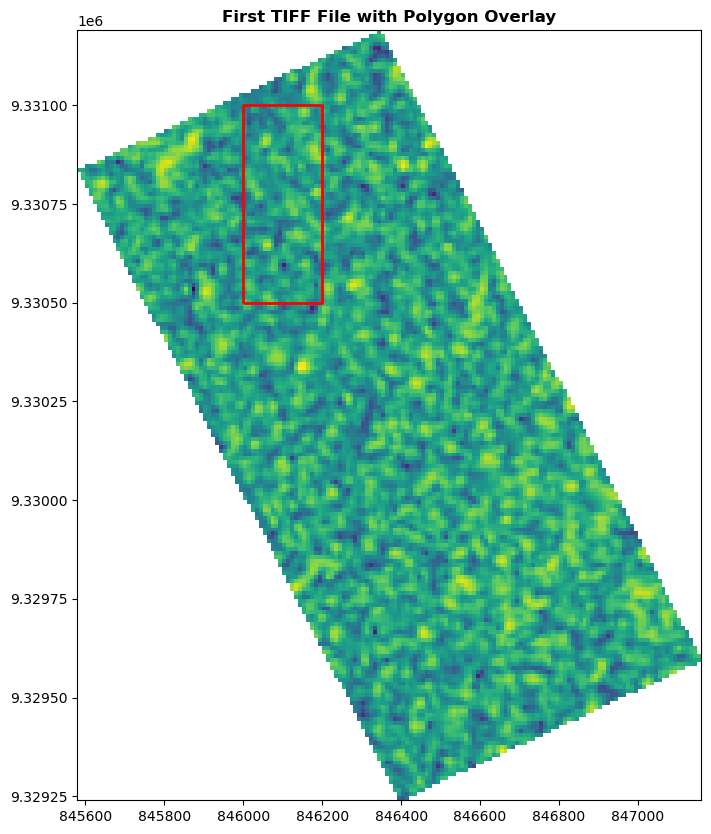

In [5]:
# Step 4: Plot the First TIFF File with the Polygon Overlaid
def plot_tif_with_polygon(tif_path, polygon_gdf):
    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot the TIFF image (first band for visualization)
        show(src, ax=ax, title="First TIFF File with Polygon Overlay")

        # Plot the polygon on top
        polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

        # Set the extent of the plot to the bounds of the image
        ax.set_xlim(src.bounds.left, src.bounds.right)
        ax.set_ylim(src.bounds.bottom, src.bounds.top)

        plt.show()

# Plot the first TIFF file with the polygon
plot_tif_with_polygon(os.path.join(time_series_dir, tif_files[0]), gdf)

In [6]:
# Step 5: Load the SVM Model and Scaler
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\rf_model.pkl'
# model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl'
forest_classifier = joblib.load(model_path)

scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl'
scaler = joblib.load(scaler_path)

In [7]:
# Step 6: Define the Feature Extraction Function
# def extract_features_from_tile(tile):
#     """Extract features from the first two bands (VV, VH) and their ratios to the mean of the Incidence Angle."""
#     band1, band2, band3 = tile
    
#     # Calculate the mean of the incidence angle (band3)
#     band3_mean = np.nanmean(band3)
    
#     # Flatten the bands
#     band1_flat = band1.flatten()
#     band2_flat = band2.flatten()
    
#     # Calculate the ratio features
#     band1_ratio = band1_flat / band3_mean
#     band2_ratio = band2_flat / band3_mean
    
#     # Stack the features together
#     tile_features = np.vstack([band1_flat, band2_flat, band1_ratio, band2_ratio]).T
    
#     return tile_features

# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH) and the incidence angle."""
#     band1, band2, band3 = image_data
#     return np.vstack([band1.flatten(), band2.flatten(), band3.flatten()]).T

def extract_features(image_data):
    """Extract features from the first two bands (VV, VH) only."""
    band1, band2 = image_data[0], image_data[1]
    return np.vstack([band1.flatten(), band2.flatten()]).T

# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH) and their ratios to the mean of the incidence angle."""
#     band1, band2, band3 = image_data
    
#     # Calculate the mean of the incidence angle (band3)
#     band3_mean = np.nanmean(band3)
    
#     # Flatten the bands
#     band1_flat = band1.flatten()
#     band2_flat = band2.flatten()
    
#     # Calculate the ratio features
#     band1_ratio = band1_flat / band3_mean
#     band2_ratio = band2_flat / band3_mean
    
#     # Stack the features together
#     features = np.vstack([band1_flat, band2_flat, band1_ratio, band2_ratio]).T
    
#     return features

In [8]:
# Step 7: Define the Deforestation Detection Function
def is_deforested(predictions, threshold=0.5):
    """Determine if the area is deforested based on the threshold."""
    non_forest_percentage = np.mean(predictions == 0)
    return non_forest_percentage > threshold


In [9]:
def extract_date_from_filename(filename):
    """Extract the date from the filename, assuming the date is in a specific position."""
    date_str = filename.split('_')[4]  # Adjust based on your file name pattern
    return datetime.strptime(date_str, "%Y%m%dT%H%M%S").date()

def classify_and_detect_deforestation(polygon_gdf, tif_files):
    # Sort the files by date before processing
    tif_files = sorted(tif_files, key=extract_date_from_filename)
    
    previous_classification = None
    total_files = len(tif_files)
    non_forest_summary = []
    initial_predictions = None  # To store the initial prediction map
    initial_file_date = None
    deforestation_detected = False  # Track if deforestation has been detected

    for index, tif_file in enumerate(tif_files):
        sys.stdout.write(f"\rProcessing file {index + 1} out of {total_files}...")
        sys.stdout.flush()

        tif_path = os.path.join(time_series_dir, tif_file)
        with rasterio.open(tif_path) as src:
            out_image, out_transform = mask(src, polygon_gdf.geometry, crop=True)
            out_image = out_image.astype(np.float32)
            out_image = np.nan_to_num(out_image, nan=-9999)

            h, w = out_image.shape[1], out_image.shape[2]
            valid_features = []

            for i in range(h):
                for j in range(w):
                    tile_features = extract_features(out_image[:, i:i+1, j:j+1])
                    if tile_features is not None:
                        valid_features.append(tile_features)

            if not valid_features:
                continue

            # Convert list of features into a 2D numpy array
            valid_features = np.vstack(valid_features)

            # Normalize the features using the scaler
            valid_features_normalized = scaler.transform(valid_features)

            # Classify the pixels using the SVM model
            predictions = forest_classifier.predict(valid_features_normalized).reshape(h, w)

            # Store the initial prediction map and date
            if initial_predictions is None:
                initial_predictions = predictions
                initial_file_date = extract_date_from_filename(tif_file)

            # Calculate the number of non-forest pixels and the percentage
            non_forest_pixels = np.sum(predictions == 0)
            total_pixels = predictions.size
            non_forest_percentage = (non_forest_pixels / total_pixels) * 100

            # Extract the date from the filename (already done in sorting)
            file_date = extract_date_from_filename(tif_file)

            # Store the summary data
            non_forest_summary.append((file_date, non_forest_percentage))

            if non_forest_percentage > 50 and not deforestation_detected:
                deforestation_detected = True
                print(f"\nDeforestation detected on: {file_date}")
                visualize_predictions(initial_predictions, initial_file_date, predictions, file_date, out_transform)
                visualize_change_groups(initial_predictions, predictions, initial_file_date, file_date, out_transform)

            previous_classification = predictions

    # Only print "No deforestation detected" if none was found
    if not deforestation_detected:
        print("\nNo significant deforestation detected in the given time series.")

    # Plot the summary at the end, and pass tif_files to the function
    plot_non_forest_percentage(non_forest_summary, tif_files)


def plot_non_forest_percentage(non_forest_summary, tif_files):
    """Plot the non-forest percentage over time with custom point colors based on file name prefix."""
    dates, percentages = zip(*non_forest_summary)

    # Create a color map for the points based on the file name prefix
    colors = []
    for tif_file in tif_files:
        if tif_file.startswith('S1A'):
            colors.append('green')
        elif tif_file.startswith('S1B'):
            colors.append('red')
        else:
            colors.append('blue')  # Default color if neither S1A nor S1B

    plt.figure(figsize=(14, 7))
    plt.plot(dates, percentages, linestyle='-', color='blue', alpha=0.7, label='Non-Forest %')

    # Plot points with custom colors
    for i, (date, percentage) in enumerate(zip(dates, percentages)):
        plt.scatter(date, percentage, color=colors[i], s=50)  # Adjust 's' for marker size

    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

    plt.xlabel('Date')
    plt.ylabel('Non-Forest Percentage (%)')
    plt.title('Non-Forest Percentage Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, transform):
    """Visualize the initial and final predictions side by side with a binary legend and projection values."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Map predictions to colors (forest: green, non-forest: brown)
    cmap = mcolors.ListedColormap(['brown', 'green'])
    
    # Initial map
    im1 = axes[0].imshow(initial_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * initial_predictions.shape[1],
                                                                 transform[5] + transform[4] * initial_predictions.shape[0], transform[5]])
    axes[0].set_title(f"Initial Predictions on {initial_file_date}")
    axes[0].set_xlabel("X Projection (m)")
    axes[0].set_ylabel("Y Projection (m)")
    axes[0].set_xticks([])  # Remove x-axis ticks for clarity

    # Final map
    im2 = axes[1].imshow(final_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * final_predictions.shape[1],
                                                               transform[5] + transform[4] * final_predictions.shape[0], transform[5]])
    axes[1].set_title(f"Predictions on {final_file_date}")
    axes[1].set_xlabel("X Projection (m)")
    axes[1].set_ylabel("Y Projection (m)")

    # Create a custom legend
    legend_labels = {0: 'Non-Forest', 1: 'Forest'}
    patches = [plt.matplotlib.patches.Patch(color=cmap(i), label=legend_labels[i]) for i in legend_labels]
    fig.legend(handles=patches, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2)
    
    plt.tight_layout()
    plt.show()

def visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, transform):
    """Visualize the changes in land cover with four groups."""
    
    # Adjust the sizes to match by trimming the larger array
    min_h = min(initial_predictions.shape[0], final_predictions.shape[0])
    min_w = min(initial_predictions.shape[1], final_predictions.shape[1])
    
    initial_predictions = initial_predictions[:min_h, :min_w]
    final_predictions = final_predictions[:min_h, :min_w]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a map for the four groups
    map_output = np.zeros_like(initial_predictions)

    # Define the four groups
    map_output[(initial_predictions == 1) & (final_predictions == 1)] = 1  # Forest that stayed forest (green)
    map_output[(initial_predictions == 1) & (final_predictions == 0)] = 2  # Forest that deforested (red)
    map_output[(initial_predictions == 0) & (final_predictions == 0)] = 3  # Non-forest that stayed non-forest (brown)
    map_output[(initial_predictions == 0) & (final_predictions == 1)] = 4  # Non-forest that became forest (light green)

    # Define the colormap
    cmap = mcolors.ListedColormap(['green', 'red', 'brown', 'lightgreen'])
    
    # Plot the map
    im = ax.imshow(map_output, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * map_output.shape[1],
                                                  transform[5] + transform[4] * map_output.shape[0], transform[5]])

    ax.set_title(f"Land Cover Change: Initial ({initial_file_date}) to Final ({final_file_date})")
    ax.set_xlabel("X Projection (m)")
    ax.set_ylabel("Y Projection (m)")

    # Create a custom legend
    legend_labels = {
        1: 'Forest stayed Forest',
        2: 'Forest deforested',
        3: 'Non-Forest stayed Non-Forest',
        4: 'Non-Forest became Forest'
    }
    # Use the correct indices for the legend
    patches = [plt.matplotlib.patches.Patch(color=cmap(i-1), label=legend_labels[i]) for i in range(1, 5)]
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()




Processing file 185 out of 241...
Deforestation detected on: 2021-07-13


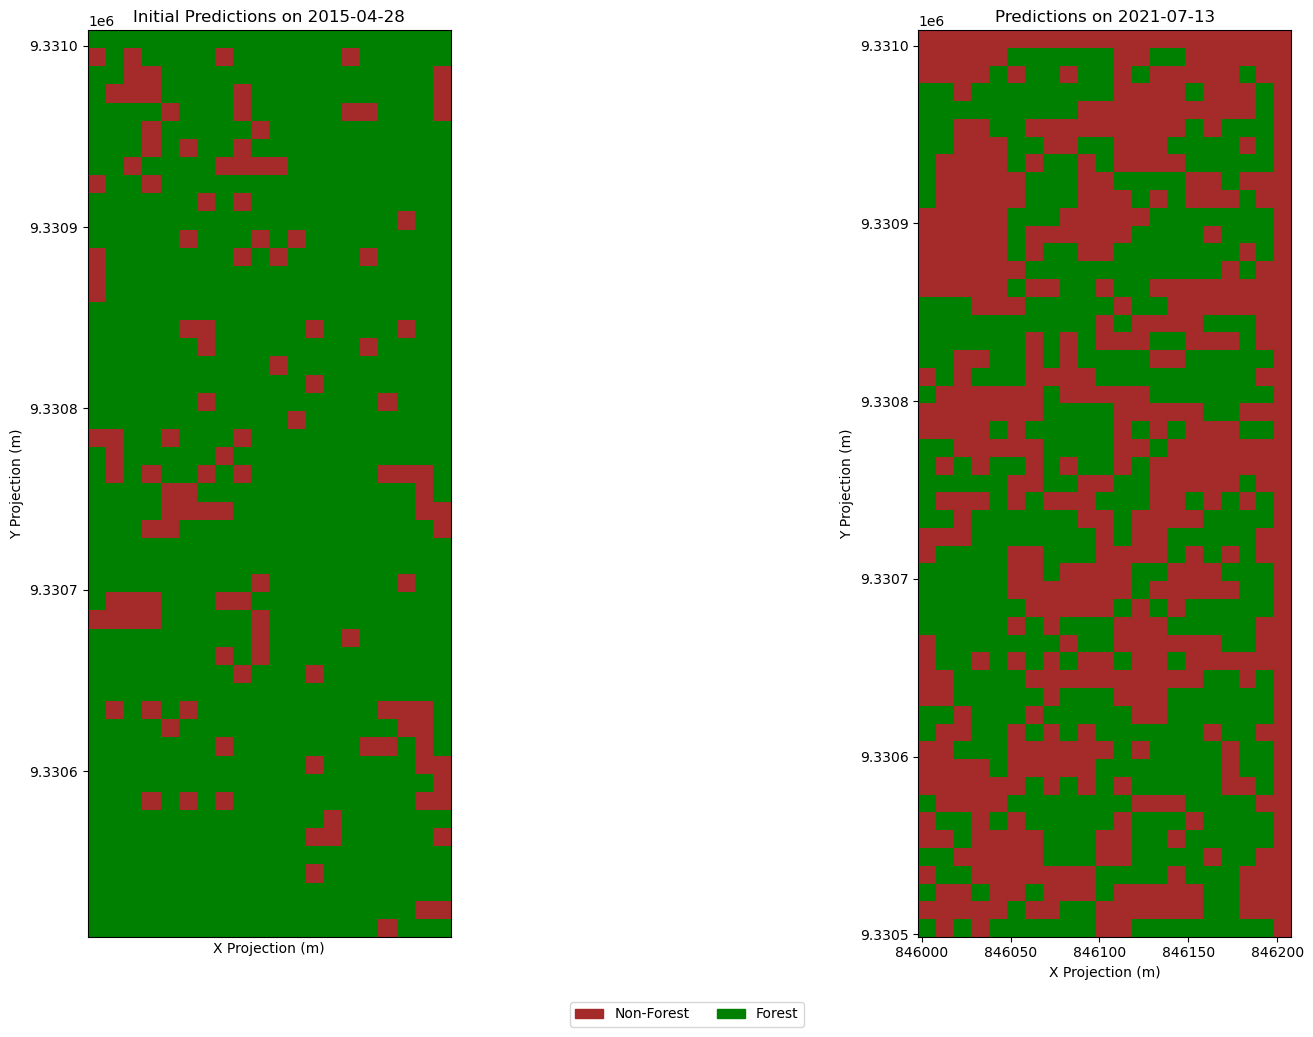

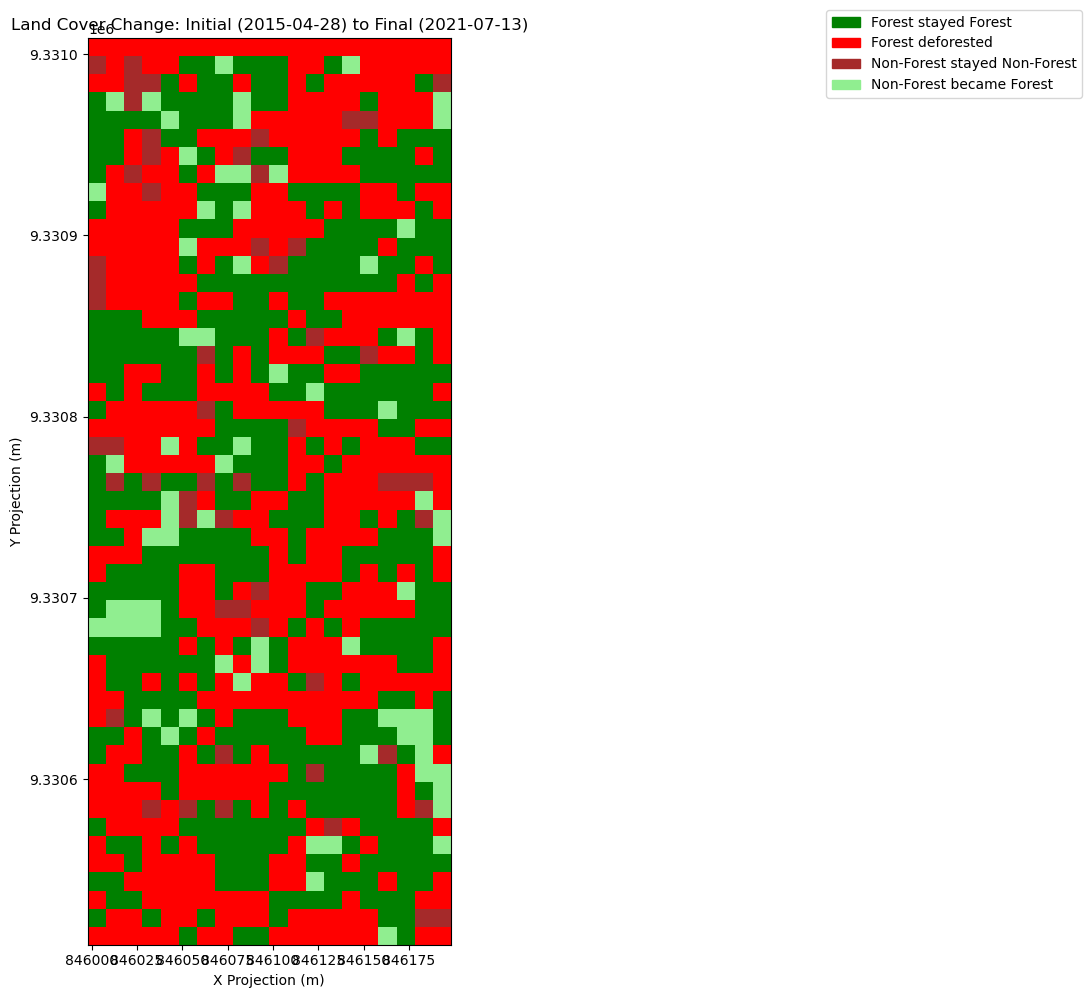

Processing file 241 out of 241...

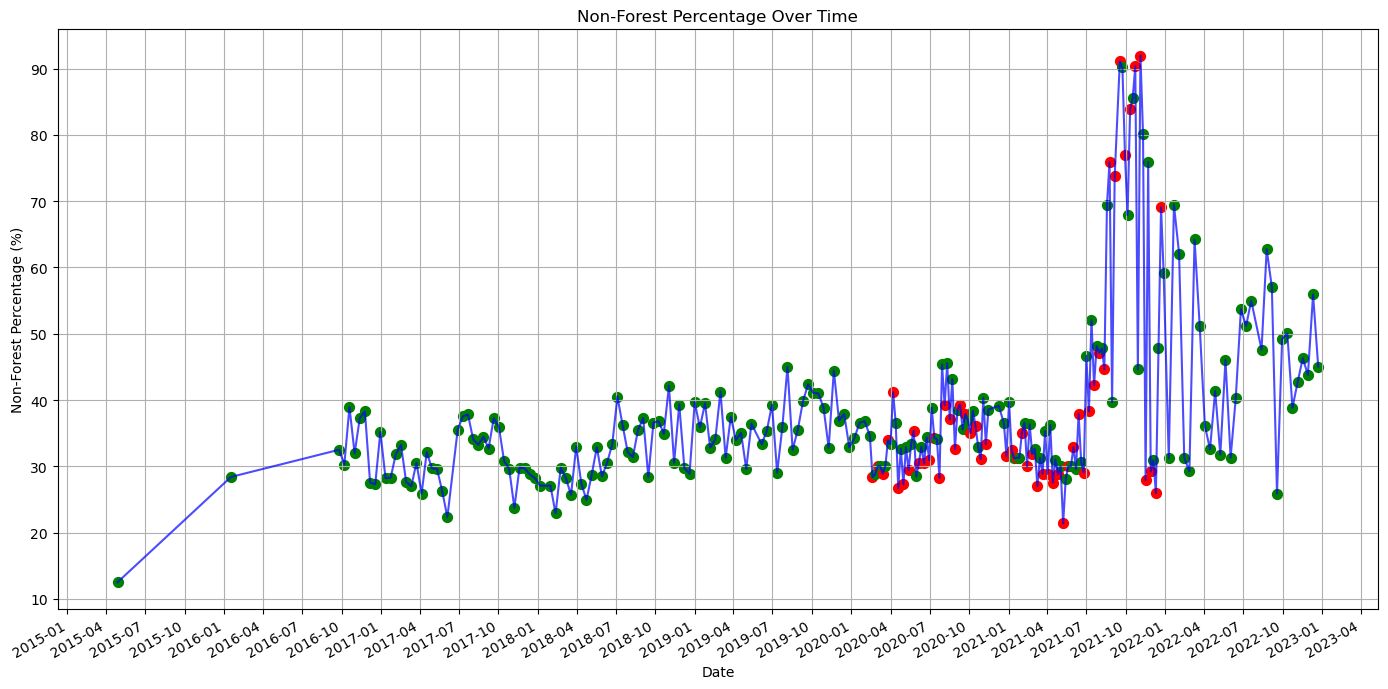

In [10]:
# Step 8: Run the Deforestation Detection Process
deforestation_date = classify_and_detect_deforestation(gdf, tif_files)